In [1]:
from sklearn.linear_model import LinearRegression
import math
from itertools import product
from scipy.special import legendre 
from sklearn.metrics import mean_squared_error
import sys
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from aPCE import *
import seaborn as sns
from AFVB_PCE import *
from VRVM_PCE import *

In [2]:
import scipy.integrate as integrate
import scipy.special as special
import time

## Ishigami Function

In [3]:
N = 320 # Sample size
N_test = 80
d = 3  # d --> number of random variables
p = 12 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

### Data

In [4]:
#np.random.seed(100)
#noise = np.random.normal(0, 0.01, (N, d)) 

X = np.random.uniform(-np.pi, np.pi, size=(N, d)) #+ noise
X_pol = np.random.uniform(-np.pi, np.pi, size=(N, d))
X_test = np.random.uniform(-np.pi, np.pi, size=(N_test, d))

In [5]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [6]:
idx = multivariate_pce_index(d, p)

In [7]:
a = 7
b = 0.1
def Ishigami_Function(dat):
    Z = dat
    return np.c_[np.sin(Z[:,0]) + a*(np.sin(Z[:,1]))**2 + b*(Z[:,2])**4*np.sin(Z[:,0])]


In [8]:
Y = Ishigami_Function(X)

In [9]:
def basis_PCE(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            # Assuming input data is in the range [-pi, pi]
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(Z[:,j]/np.pi)
    return Phi

In [10]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [11]:
def basis_aPCE(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)

    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  mod.Pol_eval(P[j][idx[i][j]], Z[:,j])
            
    return Phi

# De-bugging aPCE 

In [14]:
np.random.seed(9)
X = np.random.uniform(-np.pi, np.pi, size=(10000, 1))
d = 1
p = 2

In [15]:
def Pol_eval(coeff, x):
    """
    Evaluates a polynomial at the value x.
    Polynomial is assumed to be in the form: c_0 + c_1*x + ... + c_n*x^n

    """

    val = 0
    for i in range(p + 1):
        val += coeff[i]*x**i

    return val

In [16]:
def Inner_prod(coeff1, coeff2, dat):
    """
    Approximates the integral of the product of 2 polynomials.
    """

    s = np.mean(Pol_eval(coeff1, dat)*Pol_eval(coeff2, dat))

    return s

In [17]:
def Create_Orthonormal_Polynomials(p):
        """
        
        """
        P = []
                    
        for j in range(d):
            # Creating Orthogonal Polynomials of size n_quad
            P_temp = np.zeros((p+1, p+1))

            P_temp[0,0] = 1

            mu = np.zeros(2*p) 
            for i in range(2*p): 
                mu[i] = np.mean(X[:,j]**i)

            mu_mat = np.zeros((p, p+1))
            for i in range(p):
                mu_mat[i,:] = mu[i:(p+1+i)]

            for i in range(1, p+1):
                A = np.zeros((i+1, i+1))
                A[-1,-1] = 1
                A[0:i,:] = mu_mat[0:i, 0:i+1]
                b = A[-1]
                a = np.zeros(p+1)
                a[0:i+1] = np.linalg.inv(A)@b
                P_temp[i, :] = a.transpose()

            # Normalizing Polynomials
            P_temp_norm = np.zeros((p+1, p+1))
            for i in range(p+1):
                #P_temp_norm[i,:] = P_temp[i,:]/self.Norm(P_temp, self.X[:,j], i)
                P_temp_norm[i,:] = P_temp[i,:]/(np.sqrt(Inner_prod(P_temp[i,:],P_temp[i,:],X[:,j])))

            # Adding Matrix with Polynomial Coefficients to P
            P.append(P_temp_norm)
            
        return P

In [18]:
P = Create_Orthonormal_Polynomials(2)

In [21]:
integrate.quad(lambda x: Pol_eval(P[0][2], x)*Pol_eval(P[0][2], x),
                     -np.pi, np.pi)[0]/(2*np.pi)

0.9996690147349514

In [25]:
Inner_prod(P[0][2], P[0][2], X)

0.9999999999999998

## Linear Regression

In [11]:
## Note: We need large value of N to get the right estimated variance for Y
## fit_intercept = False if data is centered. 
## In our case, X~U(-pi, pi) has a mean of 0 and so it is centered
LR_PCE = LinearRegression(fit_intercept = False).fit(basis_PCE(X, p), Y)
LR_aPCE = LinearRegression(fit_intercept = False).fit(basis_aPCE(X, p), Y)

In [12]:
Y_LR_PCE = basis_PCE(X_test,p)@LR_PCE.coef_.transpose()
Y_LR_aPCE = basis_aPCE(X_test,p)@LR_aPCE.coef_.transpose()

In [13]:
print(np.mean(Y_LR_PCE))
print(np.mean(Y_LR_aPCE))

3.068268536306959
3.068793479645052


In [14]:
print(np.sum((LR_PCE.coef_[0][1:])**2))
print(np.sum((LR_aPCE.coef_[0][1:])**2))

12.009158153100213
12.008057684244353


In [15]:
print(LR_PCE.coef_[0][0])
print(LR_aPCE.coef_[0][0])

2.8518400720431734
2.852292430021228


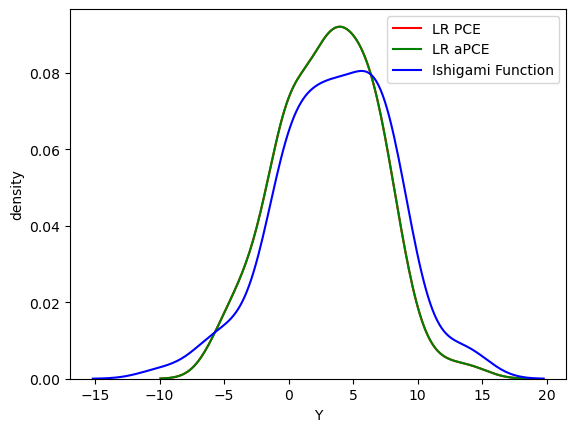

In [16]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(Y_LR_PCE.reshape(N_test), color = 'r', label='LR PCE')
sns.kdeplot(Y_LR_aPCE.reshape(N_test), color = 'g', label='LR aPCE')
sns.kdeplot(Ishigami_Function(X_test).reshape(N_test), color = 'b', label='Ishigami Function')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

## AFVB method from Bhattacharyya

## aPCE

In [19]:
## These are the optimal hyper-parameters found via GridSearchCV
# {'A_0': 1.0, 'B_0': 1e-05, 'C_0': 0.45, 'D_0': 0.00012}

In [13]:
################
#### Inputs ####
################
# A_0 and B_0 --> the parameters of the Gamma distribution in the joint Gaussian-Gamma 
# distribution used to express the prior
A_0 = 0.01 
B_0 = 0.0001 
# C_0 and D_0 --> the paramters of the Gamma distribution in the distribution of the hyper-prior
C_0 = 0.01
D_0 = 0.0001 
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000 # e --> ddjustable parameter for the threshold value 

In [14]:
mod_AFVB = AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e).fit(X,Y)

In [15]:
Phi_hat = mod_AFVB.Phi_hat 
a_hat = mod_AFVB.a_hat 
Phi_full = mod_AFVB.Phi_full 
a_full = mod_AFVB.a_full
active_cols = mod_AFVB.active_cols

In [16]:
np.sum(a_hat[1:]**2)

13.408862695692545

In [17]:
a_hat[0][0]

3.5465017746317598

In [18]:
RMSE_full_Test_B = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_AFVB.predict(X_test)))
RMSE_AFVB_Test = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_AFVB.predict(X_test, active_cols)))

In [19]:
print("RMSE_full - Testing Data:", RMSE_full_Test_B)
print("RMSE-AFVB_sparse - Testing Data:", RMSE_AFVB_Test)

RMSE_full - Testing Data: 0.0003745559763481099
RMSE-AFVB_sparse - Testing Data: 0.0005262782270039616


In [20]:
RMSE_full_Train_B = np.sqrt(mean_squared_error(Ishigami_Function(X), mod_AFVB.predict(X)))
RMSE_AFVB_Train = np.sqrt(mean_squared_error(Ishigami_Function(X), mod_AFVB.predict(X, active_cols)))

In [21]:
print("RMSE_full - Training Data:", RMSE_full_Train_B)
print("RMSE_AFVB_sparse - Training Data:", RMSE_AFVB_Train)

RMSE_full - Training Data: 0.00015622433325940014
RMSE_AFVB_sparse - Training Data: 0.0003834615556160141


## Hyper-parameter Optimization using CV Using Grid Search
We might want to switch to Randomized search since we have a lot of parameters to tune

In [53]:
from sklearn.model_selection import GridSearchCV
import sklearn
import time

In [54]:
params = {'A_0': np.linspace(0.01, 1, 10),
          'B_0': np.linspace(0.00001, 0.001, 10),
          'C_0': np.linspace(0.01, 1, 10),
          'D_0': np.linspace(0.00001, 0.001, 10)}

grid_search_AFVB = GridSearchCV(AFVB_PCE(basis, p = 12),
                      param_grid = params, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 5,
                      return_train_score = True,
                      n_jobs = 4)

In [56]:
t0 = time.time()

grid_search_AFVB.fit(X, Y)

t_final = time.time() - t0

Beta_star =  1  n_star =  455
Beta_star =  70  n_star =  49
Beta_star =  68  n_star =  50
Beta_star =  69  n_star =  50
Beta_star =  65  n_star =  50
Beta_star =  75  n_star =  49
Beta_star =  75  n_star =  50
Beta_star =  74  n_star =  50
Beta_star =  77  n_star =  49
Beta_star =  79  n_star =  49
Beta_star =  79  n_star =  49
Beta_star =  83  n_star =  49
Beta_star =  82  n_star =  50
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  72  n_star =  49
Beta_star =  71  n_star =  49
Beta_star =  69  n_star =  50
Beta_star =  74  n_star =  50
Beta_star =  82  n_star =  49
Beta_star =  82  n_star =  49
Beta_star =  75  n_star =  50
Beta_star =  71  n_star =  50
Beta_star =  77  n_star =  49
Beta_star =  83  n_star =  49
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  63  n_star =  49
Beta_star =  69  n_star =  49
Beta_star =  69  n_star =  50
Beta_star =  71  n_star =  49
Beta_star =  74  n_star =  49
Beta_star =  76  n_star =  49
Beta_star =  84  n_star =  49
Beta_star =  79  n_star =  49
Beta_star =  77  n_star =  50
Beta_star =  71  n_star =  50
Beta_star =  82  n_star =  49
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  67  n_star =  49
Beta_star =  63  n_star =  49
Beta_star =  68  n_star =  49
Beta_star =  76  n_star =  49
Beta_star =  74  n_star =  49
Beta_star =  77  n_star =  49
Beta_star =  80  n_star =  50
Beta_star =  71  n_star =  50
Beta_star =  83  n_star =  49
Beta_star =  82  n_star =  49
Beta_star =  77  n_star =  50
Beta_star =  80  n_star =  50
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  2  n_star =  439
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  32  n_star =  44
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  34  n_star =  43
Beta_star =  36  n_star =  44
Beta_star =  39  n_star =  43
Beta_star =  39  n_star =  43
Beta_star =  38  n_star =  43
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  35  n_star =  46
Beta_star =  40  n_star =  45
Beta_star =  39  n_star =  45
Beta_star =  41  n_star =  46
Beta_star =  46  n_star =  45
Beta_star =  44  n_star =  46
Beta_star =  48  n_star =  45
Beta_star =  47  n_star =  45
Beta_star =  47  n_star =  46
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  28  n_star =  47
Beta_star =  28  n_star =  47
Beta_star =  34  n_star =  48
Beta_star =  34  n_star =  47
Beta_star =  37  n_star =  47
Beta_star =  36  n_star =  48
Beta_star =  41  n_star =  47
Beta_star =  41  n_star =  48
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  29  n_star =  47
Beta_star =  30  n_star =  47
Beta_star =  30  n_star =  48
Beta_star =  35  n_star =  47
Beta_star =  39  n_star =  48
Beta_star =  40  n_star =  47
Beta_star =  39  n_star =  48
Beta_star =  42  n_star =  47
Beta_star =  48  n_star =  48
Beta_star =  48  n_star =  48
Beta_star =  50  n_star =  47
Beta_star =  42  n_star =  48
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  28  n_star =  48
Beta_star =  30  n_star =  47
Beta_star =  37  n_star =  48
Beta_star =  40  n_star =  47
Beta_star =  40  n_star =  48
Beta_star =  47  n_star =  47
Beta_star =  46  n_star =  47
Beta_star =  41  n_star =  48
Beta_star =  42  n_star =  47
Beta_star =  54  n_star =  48
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  45  n_star =  44
Beta_star =  49  n_star =  44
Beta_star =  45  n_star =  45
Beta_star =  46  n_star =  44
Beta_star =  42  n_star =  44
Beta_star =  51  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  33  n_star =  45
Beta_star =  33  n_star =  45
Beta_star =  36  n_star =  45
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  31  n_star =  44
Beta_star =  31  n_star =  44
Beta_star =  38  n_star =  45
Beta_star =  40  n_star =  45
Beta_star =  42  n_star =  44
Beta_star =  43  n_star =  44
Beta_star =  47  n_star =  45
Beta_star =  46  n_star =  45
Beta_star =  46  n_star =  45
Beta_star =  46  n_star =  44
Beta_star =  55  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  30  n_star =  45
Beta_star =  30  n_star =  44
Beta_star =  37  n_star =  45
Beta_star =  36  n_star =  44
Beta_star =  42  n_star =  45
Beta_star =  42  n_star =  45
Beta_star =  43  n_star =  44
Beta_star =  43  n_star =  44
Beta_star =  52  n_star =  45
Beta_star =  47  n_star =  45
Beta_star =  50  n_star =  45
Beta_star =  52  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  45  n_star =  45
Beta_star =  46  n_star =  45
Beta_star =  46  n_star =  44
Beta_star =  48  n_star =  44
Beta_star =  49  n_star =  45
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  31  n_star =  45
Beta_star =  30  n_star =  44
Beta_star =  32  n_star =  44
Beta_star =  37  n_star =  46
Beta_star =  41  n_star =  46
Beta_star =  43  n_star =  45
Beta_star =  41  n_star =  44
Beta_star =  41  n_star =  44
Beta_star =  54  n_star =  45
Beta_star =  51  n_star =  45
Beta_star =  49  n_star =  46
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  32  n_star =  44
Beta_star =  36  n_star =  44
Beta_star =  33  n_star =  44
Beta_star =  39  n_star =  44
Beta_star =  44  n_star =  44
Beta_star =  43  n_star =  44
Beta_star =  45  n_star =  44
Beta_star =  49  n_star =  44
Beta_star =  48  n_star =  44
Beta_star =  47  n_star =  43
Beta_star =  52  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  49  n_star =  44
Beta_star =  52  n_star =  44
Beta_star =  52  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  438
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  31  n_star =  44
Beta_star =  33  n_star =  43
Beta_star =  38  n_star =  44
Beta_star =  42  n_star =  43
Beta_star =  42  n_star =  44
Beta_star =  42  n_star =  44
Beta_star =  47  n_star =  44
Beta_star =  44  n_star =  44
Beta_star =  47  n_star =  43
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  32  n_star =  44
Beta_star =  35  n_star =  44
Beta_star =  38  n_star =  44
Beta_star =  38  n_star =  44
Beta_star =  42  n_star =  43
Beta_star =  45  n_star =  44
Beta_star =  47  n_star =  44
Beta_star =  45  n_star =  43
Beta_star =  49  n_star =  44
Beta_star =  50  n_star =  44
Beta_star =  50  n_star =  44
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  31  n_star =  44
Beta_star =  34  n_star =  43
Beta_star =  37  n_star =  44
Beta_star =  40  n_star =  44
Beta_star =  39  n_star =  44
Beta_star =  43  n_star =  43
Beta_star =  46  n_star =  44
Beta_star =  50  n_star =  44
Beta_star =  49  n_star =  44
Beta_star =  50  n_star =  44
Beta_star =  47  n_star =  43
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  28  n_star =  48
Beta_star =  31  n_star =  48
Beta_star =  32  n_star =  48
Beta_star =  39  n_star =  48
Beta_star =  40  n_star =  48
Beta_star =  39  n_star =  48
Beta_star =  40  n_star =  48
Beta_star =  42  n_star =  48
Beta_star =  47  n_star =  48
Beta_star =  49  n_star =  48
Beta_star =  46  n_star =  48
Beta_star =  48  n_star =  48
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  438
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  65  n_star =  49
Beta_star =  62  n_star =  50
Beta_star =  66  n_star =  49
Beta_star =  74  n_star =  49
Beta_star =  77  n_star =  49
Beta_star =  74  n_star =  50
Beta_star =  72  n_star =  50
Beta_star =  79  n_star =  49
Beta_star =  78  n_star =  50
Beta_star =  80  n_star =  50
Beta_star =  88  n_star =  49
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  437
Beta_star 

Beta_star =  41  n_star =  44
Beta_star =  41  n_star =  44
Beta_star =  45  n_star =  45
Beta_star =  47  n_star =  46
Beta_star =  49  n_star =  45
Beta_star =  46  n_star =  44
Beta_star =  48  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  34  n_star =  45
Beta_star =  40  n_star =  45
Beta_star =  43  n_star =  45
Beta_star =  42  n_star =  46
Beta_star =  47  n_star =  45
Beta_star =  43  n_star =  44
Beta_star =  48  n_star =  44
Beta_star =  48  n_star =  46
Beta_star =  49  n_star =  45
Beta_star =  50  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  437
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  31  n_star =  43
Beta_star =  39  n_star =  43
Beta_star =  41  n_star =  43
Beta_star =  41  n_star =  43
Beta_star =  44  n_star =  43
Beta_star =  45  n_star =  43
Beta_star =  45  n_star =  43
Beta_star =  53  n_star =  43
Beta_star =  51  n_star =  43
Beta_star =  54  n_star =  43
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  32  n_star =  44
Beta_star =  37  n_star =  43
Beta_star =  34  n_star =  43
Beta_star =  35  n_star =  43
Beta_star =  44  n_star =  44
Beta_star =  43  n_star =  43
Beta_star =  46  n_star =  44
Beta_star =  49  n_star =  43
Beta_star =  46  n_star =  43
Beta_star =  47  n_star =  43
Beta_star =  52  n_star =  44
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  33  n_star =  45
Beta_star =  34  n_star =  46
Beta_star =  38  n_star =  45
Beta_star =  37  n_star =  45
Beta_star =  38  n_star =  46
Beta_star =  45  n_star =  45
Beta_star =  45  n_star =  46
Beta_star =  49  n_star =  45
Beta_star =  45  n_star =  45
Beta_star =  45  n_star =  46
Beta_star =  51  n_star =  46
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  437
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  31  n_star =  44
Beta_star =  33  n_star =  43
Beta_star =  35  n_star =  43
Beta_star =  37  n_star =  44
Beta_star =  39  n_star =  44
Beta_star =  40  n_star =  44
Beta_star =  43  n_star =  43
Beta_star =  46  n_star =  44
Beta_star =  50  n_star =  44
Beta_star =  49  n_star =  44
Beta_star =  50  n_star =  44
Beta_star =  47  n_star =  43
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  33  n_star =  43
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  28  n_star =  47
Beta_star =  34  n_star =  48
Beta_star =  36  n_star =  48
Beta_star 

Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  2  n_star =  444
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star =  1  n_star =  455
Beta_star 

Beta_star =  1  n_star =  455


In [57]:
print(t_final)

154895.82872581482


In [58]:
t_final/60/60/24

1.7927757954376717

In [60]:
grid_search_AFVB.best_params_

{'A_0': 1.0, 'B_0': 1e-05, 'C_0': 0.45, 'D_0': 0.00012}

In [114]:
# grid_search_AFVB.cv_results_

{'mean_fit_time': array([1.94631910e+01, 2.59407012e+01, 2.36512016e+01, 2.50923791e+01,
        2.54539258e+01, 5.24900956e+00, 7.39304996e+00, 9.76232944e+00,
        8.57358832e+00, 8.34122753e+00, 2.97516103e+00, 4.75177402e+00,
        5.31152244e+00, 5.51149092e+00, 5.75972304e+00, 1.42330961e+00,
        3.97014489e+00, 3.87008309e+00, 4.20500441e+00, 4.51249065e+00,
        1.37434263e+00, 5.05940576e+00, 3.65873413e+00, 3.72437348e+00,
        3.82514286e+00, 2.44399686e+01, 1.98073088e+01, 2.16690624e+01,
        2.08498658e+01, 2.01345209e+01, 5.28091054e+00, 7.37952890e+00,
        6.94044890e+00, 7.30374227e+00, 7.59549356e+00, 2.76453533e+00,
        3.87183938e+00, 4.60110683e+00, 4.78510838e+00, 4.92038784e+00,
        1.52808175e+00, 4.06876383e+00, 3.83243728e+00, 3.79914398e+00,
        3.97947426e+00, 1.32801113e+00, 4.98145404e+00, 3.86368122e+00,
        3.61773095e+00, 3.67616963e+00, 1.94441792e+01, 2.00830688e+01,
        1.82119974e+01, 1.69490694e+01, 1.73642

## Bayesian Hyperparameter Optimization

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

ImportError: cannot import name 'hp' from 'skopt' (/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/__init__.py)

In [4]:
from skopt import BayesSearchCV

In [5]:
A_0_space = hp.uniform('A_0', 0.0001, 1)
B_0_space = hp.uniform('B_0', 0.0001, 1)
C_0_space = hp.uniform('C_0', 0.0001, 1)
D_0_space = hp.uniform('D_0', 0.0001, 1)


search_space = [A_0_space, B_0_space, C_0_space, D_0_space]

NameError: name 'hp' is not defined

In [ ]:
optimizer = BayesSearchCV(AFVB_PCE(basis, p = 12),
            search_space,
            scoring = 'neg_mean_squared_error',
            cv = 5,
            n_iter = 10,
            return_train_score = True,
            n_jobs = 4
)

In [ ]:
t0 = time.time()

Bayes_Search_AFVB.fit(X, Y)

t_final = time.time() - t0

In [ ]:
Bayes_Search_AFVB.best_params_

In [ ]:
Bayes_Search_AFVB.best_score_

## PCE Using Bhattacharyya Algorithm

In [22]:
mod_AFVB_pce = AFVB_PCE(basis_PCE, p, A_0, B_0, C_0, D_0, T_ell, e).fit(X,Y)

In [23]:
Phi_hat_pce = mod_AFVB_pce.Phi_hat 
a_hat_pce = mod_AFVB_pce.a_hat 
Phi_full_pce = mod_AFVB_pce.Phi_full 
a_full_pce = mod_AFVB_pce.a_full
active_cols_pce = mod_AFVB_pce.active_cols

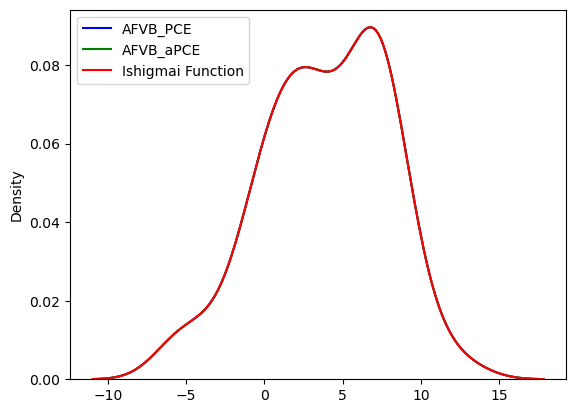

In [24]:
sns.kdeplot(mod_AFVB_pce.predict(X_test, active_cols_pce).reshape(N_test), color='b', label='AFVB_PCE')
sns.kdeplot(mod_AFVB.predict(X_test, active_cols).reshape(N_test), color='g', label='AFVB_aPCE')
sns.kdeplot(Ishigami_Function(X_test).reshape(N_test), color='r', label='Ishigmai Function')
plt.legend();

In [25]:
RMSE_full_pce_Test_B = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_AFVB_pce.predict(X_test)))
RMSE_AFVB_pce_Test = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_AFVB_pce.predict(X_test, active_cols_pce)))

RMSE_full_pce_Train_B = np.sqrt(mean_squared_error(Ishigami_Function(X), mod_AFVB_pce.predict(X)))
RMSE_AFVB_pce_Train = np.sqrt(mean_squared_error(Ishigami_Function(X), mod_AFVB_pce.predict(X, active_cols)))

In [26]:
np.sum(a_hat_pce[1:]**2)

13.844623311687792

In [27]:
a_hat_pce[0][0]

3.4999855180978985

## aPCE Using Tsilifis Algorithm

In [28]:
##########################################################################################
#### Generate N samples for d random variables and compute the responses at N samples ####
##########################################################################################
# ---- Setting the example: Coeffs, data and chaos model ------

sys.path.append('..')

data={'xi': X}
data['y'] = Y.reshape(N)


In [29]:
# The success probability for the Bernoulli dinsities is a/(a+b)
# Choices of these parameters allow controling the level of sparsity in the model
a_0 = 0.2
b_0 = 1.0

mod_VRVM = SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0).fit(data['xi'], data['y'])

c_sol = mod_VRVM.c_sol
omega_sol = mod_VRVM.omega_sol
tau_sol = mod_VRVM.tau_sol
z_sol = mod_VRVM.z_sol
pi_sol = mod_VRVM.pi_sol
iters = mod_VRVM.iters
elbo = mod_VRVM.elbo

In [30]:
active_indices = np.array(range(0,n))[z_sol>0.01]

In [31]:
c_sol[0,0]

3.546512872433862

In [32]:
np.sum((c_sol[active_indices[1:],0])**2)

13.408843769916958

In [33]:
#mod_VRVM._chaos_model._coeffs = c_sol[:,0]

In [34]:
RMSE_full_Train_T = np.sqrt(mean_squared_error(Y, mod_VRVM.predict(X)))
RMSE_VRVM_Train = np.sqrt(mean_squared_error(Y, mod_VRVM.predict(X, active_indices)))

In [35]:
print("RMSE_full - Training Data:", RMSE_full_Train_T)
print("RMSE_VRVM_sparse - Training Data:", RMSE_VRVM_Train)

RMSE_full - Training Data: 0.0005560003906630569
RMSE_VRVM_sparse - Training Data: 0.00030463538065856867


In [36]:
RMSE_full_Test_T = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_VRVM.predict(X_test)))
RMSE_VRVM_Test = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_VRVM.predict(X_test, active_indices)))

In [37]:
print("RMSE_full - Testing Data:", RMSE_full_Test_T)
print("RMSE_VRVM_sparse - Testing Data:", RMSE_VRVM_Test)

RMSE_full - Testing Data: 0.0005122560708883681
RMSE_VRVM_sparse - Testing Data: 0.0005071007091211361


## Hyper-parameter Optimization using CV Using Grid Search

In [34]:
params = {'omega_a': np.linspace(1e-7, 1e-5, 10),
          'omega_b': np.linspace(1e-7, 1e-5, 10),
          'tau_a': np.linspace(1e-7, 1e-5, 10),
          'tau_b': np.linspace(1e-7, 1e-5, 10),
          'pi_a': np.linspace(0.2/10, 0.2*10, 10),
          'pi_b': np.linspace(0.1, 10, 10),}

grid_search_VRVM = GridSearchCV(SparseVariationalOptimizer(basis, p = 12),
                      param_grid = params, 
                      scoring = 'neg_root_mean_squared_error', 
                      cv = 5,
                      return_train_score = True,
                      n_jobs = 4)

NameError: name 'basis' is not defined

In [63]:
import time

In [ ]:
t0 = time.time()

grid_search_VRVM.fit(data['xi'], data['y'])

t_final = time.time() - t0

In [ ]:
print(t_final)

In [37]:
grid_search_VRVM.best_params_

{'p': 12}

In [36]:
grid_search_VRVM.cv_results_

{'mean_fit_time': array([12.0214684 , 20.9501616 , 30.43831687]),
 'std_fit_time': array([7.78713445, 3.3915725 , 5.57034032]),
 'mean_score_time': array([0.03011146, 0.04932733, 0.07728367]),
 'std_score_time': array([0.00249478, 0.00607378, 0.01016096]),
 'param_p': masked_array(data=[10, 12, 14],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'p': 10}, {'p': 12}, {'p': 14}],
 'split0_test_score': array([-0.00943319, -0.00177362, -0.00217824]),
 'split1_test_score': array([-0.00569047, -0.00066154, -0.00107582]),
 'split2_test_score': array([-0.00687769, -0.00051601, -0.00135099]),
 'split3_test_score': array([-0.00699264, -0.00186691, -0.00169648]),
 'split4_test_score': array([-0.00547861, -0.00040393, -0.00156034]),
 'mean_test_score': array([-0.00689452, -0.0010444 , -0.00157238]),
 'std_test_score': array([0.00140778, 0.00063942, 0.00036829]),
 'rank_test_score': array([3, 1, 2], dtype=int32),
 'split0_train_score': arr

## PCE using Tsilifis Algorithm

In [38]:
a_0 = 0.2
b_0 = 1.0

mod_VRVM_pce = SparseVariationalOptimizer(basis_PCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0).fit(data['xi'], data['y'])

c_sol_pce = mod_VRVM_pce.c_sol
omega_sol_pce = mod_VRVM_pce.omega_sol
tau_sol_pce = mod_VRVM_pce.tau_sol
z_sol_pce = mod_VRVM_pce.z_sol
pi_sol_pce = mod_VRVM_pce.pi_sol
iters_pce = mod_VRVM_pce.iters
elbo_pce = mod_VRVM_pce.elbo

In [39]:
active_indices_pce = np.array(range(0,n))[z_sol_pce>0.01]

In [40]:
c_sol_pce[0,0]

3.499986177746065

In [41]:
np.sum((c_sol_pce[active_indices[1:],0])**2)

13.844667847666534

In [42]:
#mod_VRVM_pce._chaos_model._coeffs = c_sol_pce[:,0]

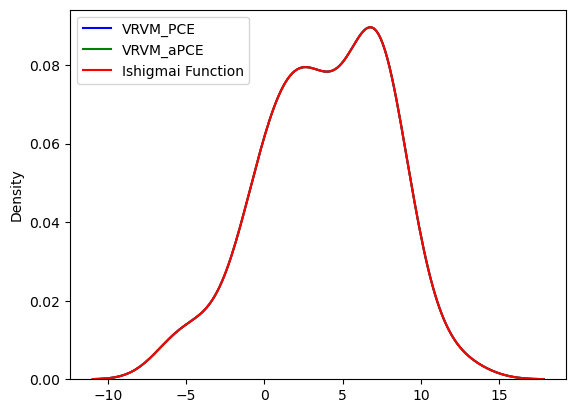

In [43]:
sns.kdeplot((mod_VRVM_pce.predict(X_test, active_indices_pce)).reshape(N_test), color='b', label='VRVM_PCE')
sns.kdeplot((mod_VRVM.predict(X_test, active_indices)).reshape(N_test), color='g', label='VRVM_aPCE')
sns.kdeplot(Ishigami_Function(X_test).reshape(N_test), color='r', label='Ishigmai Function')
plt.legend();

In [44]:
RMSE_full_pce_Train_T = np.sqrt(mean_squared_error(Y, mod_VRVM_pce.predict(X)))
RMSE_VRVM_pce_Train = np.sqrt(mean_squared_error(Y, mod_VRVM_pce.predict(X, active_indices_pce)))

RMSE_full_pce_Test_T = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_VRVM_pce.predict(X_test)))
RMSE_VRVM_pce_Test = np.sqrt(mean_squared_error(Ishigami_Function(X_test), mod_VRVM_pce.predict(X_test, active_indices_pce)))

# Summary of Results: Ishigami Function

In [126]:
data = [['a_hat.shape[0]', RMSE_full_Train_B, RMSE_AFVB_Train, RMSE_full_Test_B, RMSE_AFVB_Test], 
        [a_hat_pce.shape[0], RMSE_full_pce_Train_B, RMSE_AFVB_pce_Train, RMSE_full_pce_Test_B, RMSE_AFVB_pce_Test],
        [active_indices.shape[0], RMSE_full_Train_T, RMSE_VRVM_Train, RMSE_full_Test_T, RMSE_VRVM_Test],
        [active_indices_pce.shape[0], RMSE_full_pce_Train_T, RMSE_VRVM_pce_Train, RMSE_full_pce_Test_T, RMSE_VRVM_pce_Test]]
  
df = pd.DataFrame(data, columns=['n_star', 'RMSE_Train_full', 'RMSE_Train_sparse', 'RMSE_Test_full', 'RMSE_Test_sparse'])
df.index = ['AFVB_aPCE', 'AFVB_PCE', 'VRVM_aPCE', 'VRVM_PCE']

print('p = ', p)
print('N = ', N)
print('n = ', n)
df

p =  12
N =  320
n =  455


,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse
AFVB_aPCE,a_hat.shape[0],0.000156,0.000383,0.000375,0.000526
AFVB_PCE,21,0.000165,0.000264,0.000248,0.000249
VRVM_aPCE,48,0.000556,0.000305,0.000512,0.000507
VRVM_PCE,21,0.000490,0.000249,0.000322,0.000272


<Axes: >

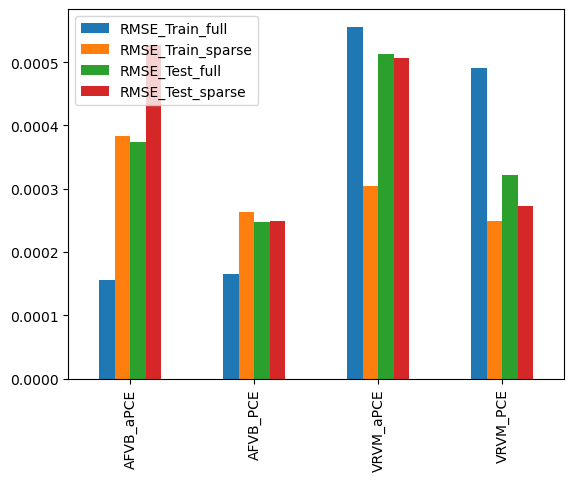

In [127]:
df.plot.bar()

In [111]:
data_AFVB = [[RMSE_full_Test_B, RMSE_AFVB_Test], 
        [RMSE_full_pce_Test_B, RMSE_AFVB_pce_Test]]
df_AFVB = pd.DataFrame(data_AFVB, columns=['Full Expansion', 'Sparse Expansion'])
df_AFVB.index = ['aPCE', 'PCE']

data_VRVM = [[RMSE_full_Test_T, RMSE_VRVM_Test], 
        [RMSE_full_pce_Test_T, RMSE_VRVM_pce_Test]]
df_VRVM = pd.DataFrame(data_VRVM, columns=['Full Expansion', 'Sparse Expansion'])
df_VRVM.index = ['aPCE', 'PCE']

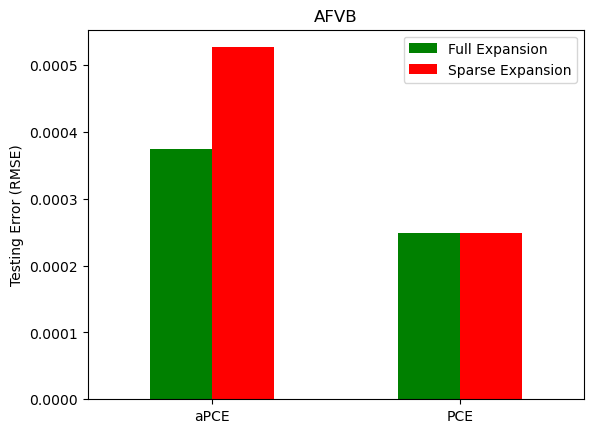

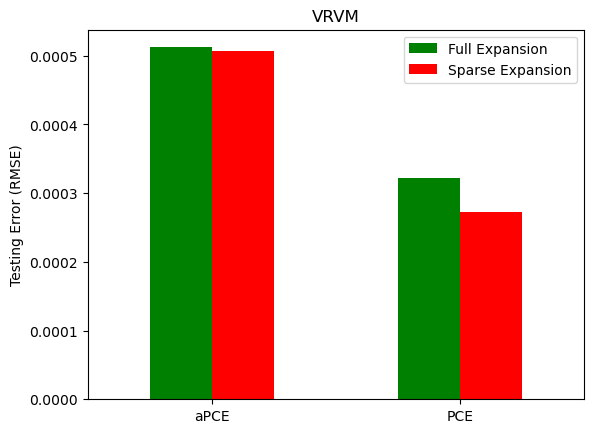

In [125]:
ax1 = df_AFVB.plot.bar(rot = 0, color = ['g', 'r'], title = 'AFVB')
ax1.set_ylabel("Testing Error (RMSE)")

ax2 = df_VRVM.plot.bar(rot = 0, color = ['g', 'r'], title = "VRVM")
ax2.set_ylabel("Testing Error (RMSE)");

## GSA

In [46]:
def GSA(a, idx, active_cols):
    
    V = np.sum(a[1:]**2)
    V_Partial = []
    V_Total = []
    S_Partial = []
    S_Total = []
    
    l = [0,1,2]
    
    for k in range(3):
        l = [0,1,2]
        l.remove(k)
        
        temp = np.full(idx[active_cols].shape[0], True, dtype = bool)
        
        for i in range(idx[active_cols].shape[0]):
            temp[i] = (idx[active_cols][i][k] != 0) & (sum(idx[active_cols][i][l]) == 0)
            
        V_Partial.append(np.sum(a[temp,:]**2))
        S_Partial.append(np.sum(a[temp,:]**2)/V)

        for i in range(idx[active_cols].shape[0]):
            temp[i] = idx[active_cols][i][k] != 0

        V_Total.append(np.sum(a[temp,:]**2))
        S_Total.append(np.sum(a[temp,:]**2)/V)

    
    
    return [V], V_Partial, V_Total, S_Partial, S_Total

In [47]:
GSA_AFVB_aPCE = GSA(a_hat, idx, active_cols)
GSA_AFVB_PCE = GSA(a_hat_pce, idx, active_cols_pce)
GSA_VRVM_aPCE = GSA(np.c_[c_sol[active_indices,0]], idx, active_indices)
GSA_VRVM_PCE = GSA(np.c_[c_sol_pce[active_indices_pce,0]], idx, active_indices_pce)

V = 7**2/8 + 0.1*np.pi**4/5 + 0.1**2*np.pi**8/18 + 1/2
GSA_True = ([V],
                   [1/2*(1+0.1*np.pi**4/5)**2, 7**2/8, 0],
                   [1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225, 7**2/8, 8*0.1**2*np.pi**8/225],
                   [1/2*(1+0.1*np.pi**4/5)**2/V, 7**2/8/V, 0],
                   [(1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225)/V, 7**2/8/V, 8*0.1**2*np.pi**8/225/V])
                

In [48]:
data = [list(np.concatenate(list(GSA_True)).flat),
       list(np.concatenate(list(GSA_AFVB_aPCE)).flat),
       list(np.concatenate(list(GSA_AFVB_PCE)).flat),
       list(np.concatenate(list(GSA_VRVM_aPCE)).flat),
       list(np.concatenate(list(GSA_VRVM_PCE)).flat)]
  
df = pd.DataFrame(data, columns=['V', 
                                 'V1', 'V2', 'V3', 
                                 'VT1', 'VT2', 'VT3', 
                                 'S1', 'S2', 'S3', 
                                 'ST1', 'ST2', 'ST3'])

df.index = ['True', 'AFVB_aPCE', 'AFVB_PCE', 'VRVM_aPCE', 'VRVM_PCE']

In [49]:
df

,V,V1,V2,V3,VT1,VT2,VT3,S1,S2,S3,ST1,ST2,ST3
True,13.844588,4.345888,6.125000,0.000000,7.719588,6.125000,3.373700,0.313905,0.442411,0.000000,0.557589,0.442411,0.243684
AFVB_aPCE,13.838087,4.323563,6.118203,0.000346,7.719538,6.118203,3.396320,0.312439,0.442128,0.000025,0.557847,0.442128,0.245433
AFVB_PCE,13.844456,4.345832,6.125115,0.000000,7.719341,6.125115,3.373509,0.313904,0.442424,0.000000,0.557576,0.442424,0.243672
VRVM_aPCE,13.838049,4.323562,6.118138,0.000346,7.719566,6.118138,3.396350,0.312440,0.442124,0.000025,0.557851,0.442124,0.245436
VRVM_PCE,13.844462,4.345842,6.125075,0.000000,7.719387,6.125075,3.373545,0.313905,0.442421,0.000000,0.557579,0.442421,0.243675


<Axes: >

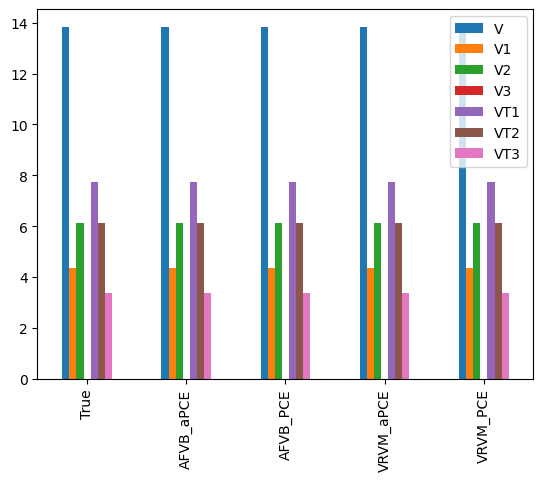

In [51]:
df[['V', 'V1', 'V2', 'V3', 'VT1', 'VT2', 'VT3']].plot.bar()

<Axes: >

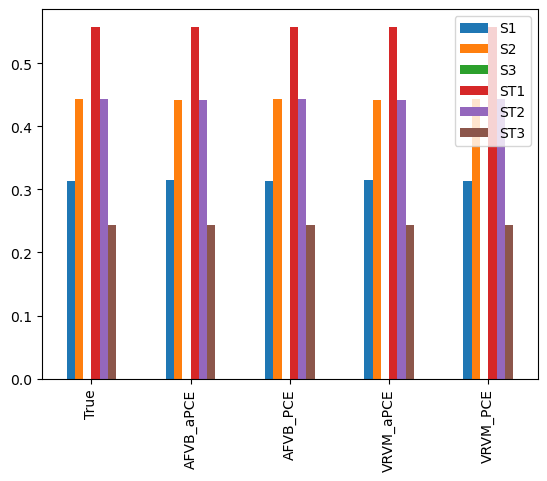

In [52]:
df[['S1', 'S2', 'S3', 'ST1', 'ST2', 'ST3']].plot.bar()

# Sobol' function

The Sobol function is given by

$$
Y = \prod_{i=1}^d\frac{|4\xi_i - 2| + a_i}{1 + a_i}
$$

where $\xi_i$ are independent random variables uniformly distributed over $[0,1]$ and $a_i$ are the constants. 


In [155]:
################
#### Inputs ####
################
N = 300 # N --> number of samples
N_test = 30
N_pol = 1000000
d = 8  # d --> number of random variables
p = 6  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion
# A_0 and B_0 --> the parameters of the Gamma distribution in the joint Gaussian-Gamma 
# distribution used to express the prior
A_0 = 0.01 
B_0 = 0.0001 
# C_0 and D_0 --> the paramters of the Gamma distribution in the distribution of the hyper-prior
C_0 = 0.01
D_0 = 0.0001 
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000 # e --> ddjustable parameter for the threshold value 

alpha = np.c_[1, 2, 5, 10, 20, 50, 100, 500]

In [156]:
#np.random.seed(10)
X = np.zeros((N, d))
for i in range(d):
    X[:,i] = np.random.uniform(0,1,N)

def Sobol_Function(Z):
    return np.c_[np.prod((np.abs(4*Z - 2) + alpha)/(1 + alpha),1)]

Y = Sobol_Function(X)

In [157]:
X_test = np.zeros((N_test, d))
for i in range(d):
    X_test[:,i] = np.random.uniform(0,1,N_test)

In [158]:
X_pol = np.zeros((N_pol, d))
for i in range(d):
    X_pol[:,i] = np.random.uniform(0,1,N_pol)

In [159]:
idx = multivariate_pce_index(d, p)

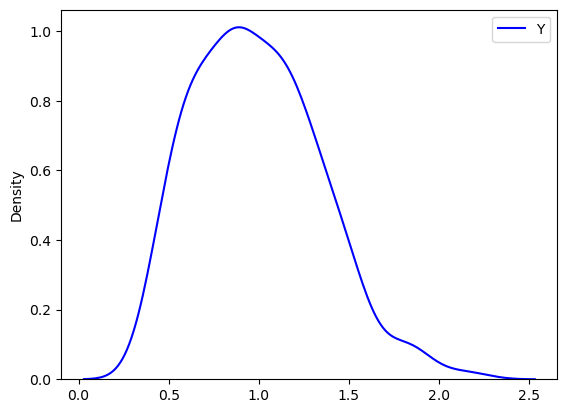

In [160]:
sns.kdeplot(Y.reshape(N), color='b', label='Y')
plt.legend();

In [ ]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [161]:
def basis_aPCE(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)

    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  mod.Pol_eval(P[j][idx[i][j]], Z[:,j])
            
    return Phi

In [162]:
t0 = time.time()
mod_AFVB = AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e).fit(X,Y)
print(time.time() - t0)

Beta_star =  109  n_star =  27
2721.5118641853333


In [163]:
Phi_hat = mod_AFVB.Phi_hat 
a_hat = mod_AFVB.a_hat 
Phi_full = mod_AFVB.Phi_full 
a_full = mod_AFVB.a_full
active_cols = mod_AFVB.active_cols

In [164]:
def basis_PCE(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

In [165]:
t0 = time.time()
mod_AFVB_pce = AFVB_PCE(basis_PCE, p, A_0, B_0, C_0, D_0, T_ell, e).fit(X,Y)
print(time.time()-t0)

Beta_star =  21  n_star =  183
4037.7180202007294


In [166]:
Phi_hat_pce = mod_AFVB_pce.Phi_hat 
a_hat_pce = mod_AFVB_pce.a_hat 
Phi_full_pce = mod_AFVB_pce.Phi_full 
a_full_pce = mod_AFVB_pce.a_full
active_cols_pce = mod_AFVB_pce.active_cols

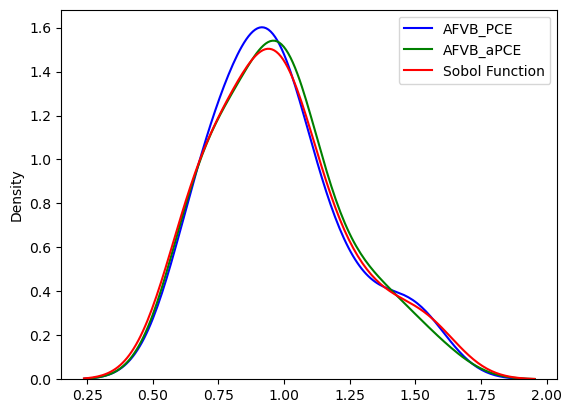

In [167]:
sns.kdeplot(mod_AFVB_pce.predict(X_test, active_cols_pce).reshape(N_test), color='b', label='AFVB_PCE')
sns.kdeplot(mod_AFVB.predict(X_test, active_cols).reshape(N_test), color='g', label='AFVB_aPCE')
sns.kdeplot(Sobol_Function(X_test).reshape(N_test), color='r', label='Sobol Function')
plt.legend();

In [168]:
RMSE_full_Test_B = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_AFVB.predict(X_test)))
RMSE_AFVB_Test = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_AFVB.predict(X_test, active_cols)))

RMSE_full_Train_B = np.sqrt(mean_squared_error(Sobol_Function(X), mod_AFVB.predict(X)))
RMSE_AFVB_Train = np.sqrt(mean_squared_error(Sobol_Function(X), mod_AFVB.predict(X, active_cols)))

In [169]:
RMSE_full_pce_Test_B = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_AFVB_pce.predict(X_test)))
RMSE_AFVB_pce_Test = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_AFVB_pce.predict(X_test, active_cols_pce)))

RMSE_full_pce_Train_B = np.sqrt(mean_squared_error(Sobol_Function(X), mod_AFVB_pce.predict(X)))
RMSE_AFVB_pce_Train = np.sqrt(mean_squared_error(Sobol_Function(X), mod_AFVB_pce.predict(X, active_cols_pce)))

In [170]:
print(RMSE_AFVB_Test)
print(RMSE_AFVB_pce_Test)

0.052296075386354654
0.055873108053092486


In [171]:
print(RMSE_AFVB_Train)
print(RMSE_AFVB_pce_Train)

0.03447543806543518
0.0015981879678637425


In [172]:
##########################################################################################
#### Generate N samples for d random variables and compute the responses at N samples ####
##########################################################################################
# ---- Setting the example: Coeffs, data and chaos model ------

sys.path.append('..')

data={'xi':X}
data['y'] = np.prod((np.abs(4*data['xi'] - 2) + alpha)/(1 + alpha),1)

In [173]:
# The success probability for the Bernoulli dinsities is a/(a+b)
# Choices of these parameters allow controling the level of sparsity in the model
a_0 = 0.2
b_0 = 1.0

t0 = time.time()
mod_VRVM = SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0).fit(data['xi'], data['y'])
print(time.time()-t0)

c_sol = mod_VRVM.c_sol
omega_sol = mod_VRVM.omega_sol
tau_sol = mod_VRVM.tau_sol
z_sol = mod_VRVM.z_sol
pi_sol = mod_VRVM.pi_sol
iters = mod_VRVM.iters
elbo = mod_VRVM.elbo

Total number of iterations : 127
n_star =  14
183.0162947177887


In [174]:
active_indices = np.array(range(0,n))[z_sol>0.01]
mod_VRVM._chaos_model._coeffs = c_sol[:,0]

In [175]:
a_0 = 0.2
b_0 = 1.0

t0 = time.time()
mod_VRVM_pce = SparseVariationalOptimizer(basis_PCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0).fit(data['xi'], data['y'])
print(time.time()-t0)

c_sol_pce = mod_VRVM_pce.c_sol
omega_sol_pce = mod_VRVM_pce.omega_sol
tau_sol_pce = mod_VRVM_pce.tau_sol
z_sol_pce = mod_VRVM_pce.z_sol
pi_sol_pce = mod_VRVM_pce.pi_sol
iters_pce = mod_VRVM_pce.iters
elbo_pce = mod_VRVM_pce.elbo

Total number of iterations : 127
n_star =  14
247.72980618476868


In [176]:
active_indices_pce = np.array(range(0,n))[z_sol_pce>0.01]
mod_VRVM_pce._chaos_model._coeffs = c_sol_pce[:,0]

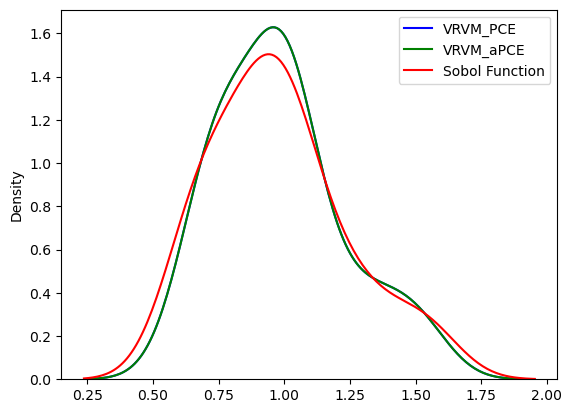

In [177]:
sns.kdeplot((mod_VRVM_pce.predict(X_test, active_indices_pce)).reshape(N_test), color='b', label='VRVM_PCE')
sns.kdeplot((mod_VRVM.predict(X_test, active_indices)).reshape(N_test), color='g', label='VRVM_aPCE')
sns.kdeplot(Sobol_Function(X_test).reshape(N_test), color='r', label='Sobol Function')
plt.legend();

In [178]:
RMSE_full_Train_T = np.sqrt(mean_squared_error(Y, mod_VRVM.predict(X)))
RMSE_VRVM_Train = np.sqrt(mean_squared_error(Y, mod_VRVM.predict(X, active_indices)))

RMSE_full_Test_T = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_VRVM.predict(X_test)))
RMSE_VRVM_Test = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_VRVM.predict(X_test, active_indices)))

In [179]:
RMSE_full_pce_Train_T = np.sqrt(mean_squared_error(Y, mod_VRVM_pce.predict(X)))
RMSE_VRVM_pce_Train = np.sqrt(mean_squared_error(Y, mod_VRVM_pce.predict(X, active_indices_pce)))

RMSE_full_pce_Test_T = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_VRVM_pce.predict(X_test)))
RMSE_VRVM_pce_Test = np.sqrt(mean_squared_error(Sobol_Function(X_test), mod_VRVM_pce.predict(X_test, active_indices_pce)))

# Summary of Results

In [182]:
data = [[a_hat.shape[0], RMSE_full_Train_B, RMSE_AFVB_Train, RMSE_full_Test_B, RMSE_AFVB_Test], 
        [a_hat_pce.shape[0], RMSE_full_pce_Train_B, RMSE_AFVB_pce_Train, RMSE_full_pce_Test_B, RMSE_AFVB_pce_Test],
        [active_indices.shape[0], RMSE_full_Train_T, RMSE_VRVM_Train, RMSE_full_Test_T, RMSE_VRVM_Test],
        [active_indices_pce.shape[0], RMSE_full_pce_Train_T, RMSE_VRVM_pce_Train, RMSE_full_pce_Test_T, RMSE_VRVM_pce_Test]]
  
df = pd.DataFrame(data, columns=['n_star', 'RMSE_Train_full', 'RMSE_Train_sparse', 'RMSE_Test_full', 'RMSE_Test_sparse'])
df.index = ['AFVB_aPCE', 'AFVB_PCE', 'VRVM_aPCE', 'VRVM_PCE']

print('p = ', p)
print('N = ', N)
print('n = ', n)
df

p =  6
N =  300
n =  3003


,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse
AFVB_aPCE,27,0.000154,0.034475,0.054981,0.052296
AFVB_PCE,183,0.000157,0.001598,0.055625,0.055873
VRVM_aPCE,14,0.033728,0.044648,0.052000,0.053883
VRVM_PCE,14,0.033643,0.044617,0.051968,0.053832


<Axes: >

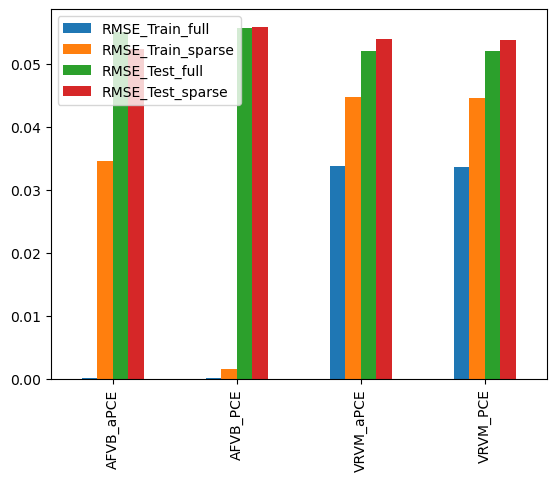

In [181]:
df.plot.bar()

In [183]:
def GSA(a, idx, active_cols):
    
    V = np.sum(a[1:]**2)
    V_Partial = []
    V_Total = []
    S_Partial = []
    S_Total = []
    
    l = [0,1,2]
    
    for k in range(8):
        l = [0,1,2,3,4,5,6,7]
        l.remove(k)
        
        temp = np.full(idx[active_cols].shape[0], True, dtype = bool)
        
        for i in range(idx[active_cols].shape[0]):
            temp[i] = (idx[active_cols][i][k] != 0) & (sum(idx[active_cols][i][l]) == 0)
            
        V_Partial.append(np.sum(a[temp,:]**2))
        S_Partial.append(np.sum(a[temp,:]**2)/V)

        for i in range(idx[active_cols].shape[0]):
            temp[i] = idx[active_cols][i][k] != 0

        V_Total.append(np.sum(a[temp,:]**2))
        S_Total.append(np.sum(a[temp,:]**2)/V)

    
    
    return S_Partial, S_Total

In [184]:
GSA_AFVB_aPCE = GSA(a_hat, idx, active_cols)
GSA_AFVB_PCE = GSA(a_hat_pce, idx, active_cols_pce)
GSA_VRVM_aPCE = GSA(np.c_[c_sol[active_indices,0]], idx, active_indices)
GSA_VRVM_PCE = GSA(np.c_[c_sol_pce[active_indices_pce,0]], idx, active_indices_pce)

GSA_True = [0.6037, 0.2683, 0.0671, 0.0200, 0.0055, 0.0009, 0.0002, 0.0000,
           0.6342, 0.2945, 0.0756, 0.0227, 0.0062, 0.0011, 0.003, 0.0000]

In [185]:
data = [GSA_True, 
       list(np.concatenate(list(GSA_AFVB_aPCE)).flat),
       list(np.concatenate(list(GSA_AFVB_PCE)).flat),
       list(np.concatenate(list(GSA_VRVM_aPCE)).flat),
       list(np.concatenate(list(GSA_VRVM_PCE)).flat)]
  
df = pd.DataFrame(data, columns=['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 
                                 'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'ST8'])

df.index = ['True', 'AFVB_aPCE', 'AFVB_PCE', 'VRVM_aPCE', 'VRVM_PCE']

In [186]:
df

,S1,S2,S3,S4,S5,S6,S7,S8,ST1,ST2,ST3,ST4,ST5,ST6,ST7,ST8
True,0.603700,0.268300,0.067100,0.020000,0.005500,0.000900,0.0002,0.0,0.634200,0.294500,0.075600,0.022700,0.006200,0.001100,0.003000,0.000000
AFVB_aPCE,0.608011,0.273265,0.067260,0.017816,0.004848,0.001052,0.0000,0.0,0.632419,0.294616,0.075141,0.018557,0.005612,0.001326,0.000672,0.001008
AFVB_PCE,0.600565,0.269982,0.066485,0.017684,0.004867,0.001022,0.0000,0.0,0.629721,0.295324,0.079166,0.022041,0.010476,0.006089,0.005896,0.005937
VRVM_aPCE,0.613868,0.263899,0.066767,0.017893,0.005122,0.000000,0.0000,0.0,0.643264,0.289375,0.076797,0.017893,0.005122,0.000000,0.000000,0.000000
VRVM_PCE,0.613888,0.263914,0.066765,0.017908,0.005130,0.000000,0.0000,0.0,0.643233,0.289351,0.076774,0.017908,0.005130,0.000000,0.000000,0.000000


In [187]:
np.sum(a_hat_pce[1:]**2)

0.13339933187464684

In [188]:
np.sum(a_hat[1:]**2)

0.1318610666244363

In [189]:
np.sum(c_sol[1:,0]**2)

0.13630188980386654

In [190]:
np.sum(c_sol_pce[1:,0]**2)

0.13621624119644063

<Axes: >

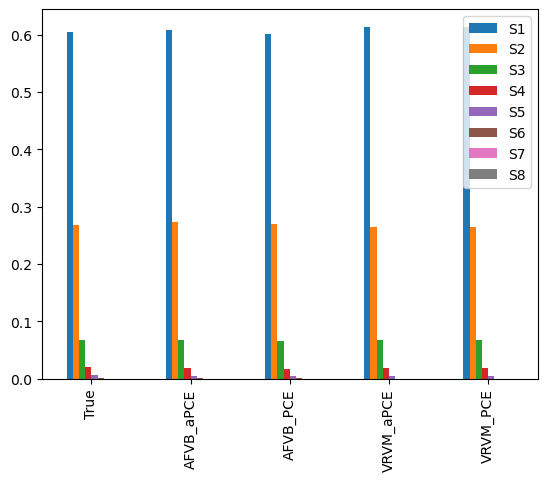

In [191]:
df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']].plot.bar()

<Axes: >

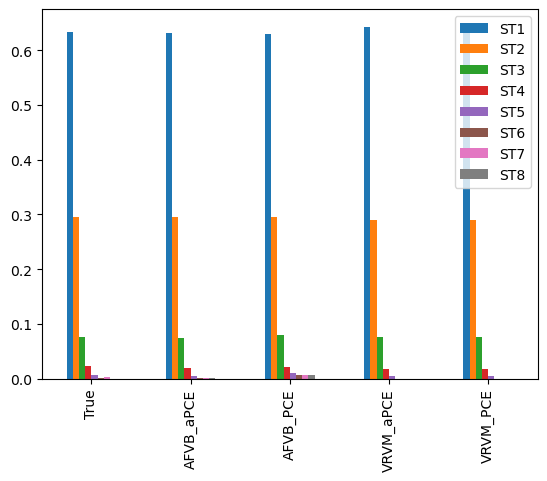

In [192]:
df[['ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'ST8']].plot.bar()